In [1]:
import os
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.manual_seed(777)  # reproducibility

# parameters
total_dog_classes = 133
learning_rate = 0.001
batch_size = 10
keep_prob = 0.7
data_dir="./all_images/dogImages/"
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'


# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),    
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
                  VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
                  TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

image_datasets = {x: dsets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [TRAIN, VAL, TEST]}



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in [TRAIN, VAL, TEST]}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
class_names = image_datasets[TRAIN].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("number of training images:", len(image_datasets[TRAIN]))
print("numbe of validation images:", len(image_datasets[VAL]))
print("number of testing images:", len(image_datasets[TEST]))

number of training images: 6680
numbe of validation images: 835
number of testing images: 836


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchsummary

# model
'''EfficientNet in PyTorch.
Paper: "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks".
Reference: https://github.com/keras-team/keras-applications/blob/master/keras_applications/efficientnet.py
'''

import torch

def swish(x):
    return x * x.sigmoid()

def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernoulli_(keep_ratio)
    x.div_(keep_ratio)
    x.mul_(mask)
    return x


class SE(nn.Module):
    '''Squeeze-and-Excitation block with Swish.'''

    def __init__(self, in_channels, se_channels):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_channels, se_channels,
                             kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_channels, in_channels,
                             kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out


class Block(nn.Module):
    '''expansion + depthwise + pointwise + squeeze-excitation'''

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 expand_ratio=1,
                 se_ratio=0.,
                 drop_rate=0.):
        super(Block, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.expand_ratio = expand_ratio

        # Expansion
        channels = expand_ratio * in_channels
        self.conv1 = nn.Conv2d(in_channels,
                               channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        # Depthwise conv
        self.conv2 = nn.Conv2d(channels,
                               channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=(1 if kernel_size == 3 else 2),
                               groups=channels,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        # SE layers
        se_channels = int(in_channels * se_ratio)
        self.se = SE(channels, se_channels)

        # Output
        self.conv3 = nn.Conv2d(channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Skip connection if in and out shapes are the same (MV-V2 style)
        self.has_skip = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0:
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=total_dog_classes):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layers = self._make_layers(in_channels=64)
        self.linear = nn.Linear(cfg['out_channels'][-1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size',
                                     'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    Block(in_channels,
                          out_channels,
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out

cfg = {
    'num_blocks': [1, 2, 2, 3, 3, 4, 1],
    'expansion': [1, 2, 2, 4, 4, 6, 6],
    'out_channels': [16, 24, 40, 80, 112, 192, 320],
    'kernel_size': [3, 3, 5, 3, 5, 5, 3],
    'stride': [1, 2, 2, 2, 1, 2, 1],
    'dropout_rate': 0.2,
    'drop_connect_rate': 0.2,
}

In [3]:
model_scratch = EfficientNet(cfg)
print(model_scratch)

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()
else:
    print("cuda is not available.")

EfficientNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SE(
        (se1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (se2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(16, 32, kernel_size=(1, 1), stride

In [4]:
import torch.optim as optim
from torch.optim import lr_scheduler
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size = 7, gamma=0.1)

In [5]:
import matplotlib.pyplot as plt
from PIL import ImageFile
import numpy as np
import time
import copy

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm
import torch

batch_size = 10
train_data = image_datasets[TRAIN]
test_data = image_datasets[TEST]
# dataloaders
train_data_loader = dataloaders[TRAIN]
valid_data_loader = dataloaders[VAL]

# training function
def fit(model, dataloader, optimizer, criterion, train_data, device, use_amp):
    print('Training')
    if use_amp == 'yes':
        scaler = torch.cuda.amp.GradScaler() 
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (image,target) in tqdm(enumerate(dataloader), total=int(len(train_data)/batch_size)):
        image, target = image.to(device), target.to(device)
        optimizer.zero_grad()
        
        if use_amp == 'yes':
            with torch.cuda.amp.autocast():
                outputs = model(image)
                loss = criterion(outputs, target)
        
        elif use_amp == 'no':
            outputs = model(image)
            loss = criterion(outputs, target)
            
        train_running_loss += (1/(i+1))*(loss.item() - train_running_loss)
        _, preds = torch.max(outputs, 1)
        train_running_correct += (preds == target).sum().item()
        
        if use_amp == 'yes':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        elif use_amp == 'no':
            loss.backward()
            optimizer.step()
        
    train_loss = train_running_loss
    train_accuracy = 100. * train_running_correct/dataset_sizes[TRAIN]    
    return train_loss, train_accuracy

# validation function
def validate(model, dataloader, optimizer, criterion, val_data, device, use_amp):
    print('Validating')
    if use_amp == True:
        scaler = torch.cuda.amp.GradScaler() 
        
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, (image,target) in tqdm(enumerate(dataloader), total=int(len(val_data)/batch_size)):
            image, target = image.to(device), target.to(device)
            
            if use_amp == 'yes':
                with torch.cuda.amp.autocast():
                    outputs = model(image)
                    loss = criterion(outputs, target)
        
            elif use_amp == 'no':
                outputs = model(image)
                loss = criterion(outputs, target)
            
            val_running_loss += (1/(i+1))*(loss.item() - val_running_loss)
            _, preds = torch.max(outputs, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss
        val_accuracy = 100. * val_running_correct/dataset_sizes[VAL]        
        return val_loss, val_accuracy
    
def train(epochs, model, criterion, optimizer, scheduler):
    since = time.time()
     
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    use_amp = input("Do you want to use amp? (yes/no)")
    if use_amp == 'yes':
        print('Tranining and validating with Automatic Mixed Precision')
    else:
        print('Tranining and validating without Automatic Mixed Precision')
    
    start = time.time()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_accuracy = fit(model, train_data_loader, 
                                                     optimizer, criterion, 
                                                     train_data, device, use_amp)
        val_epoch_loss, val_epoch_accuracy = validate(model, valid_data_loader, 
                                                     optimizer, criterion, 
                                                     test_data, device, use_amp)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_accuracy)
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
    end = time.time()
    print(f"Took {((end-start)/60):.3f} minutes to train for {epochs} epochs")

    # save model checkpoint
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"./graphs/condense_amp_{use_amp}_model.pt")
    
    return train_loss, val_loss, train_acc, val_acc, use_amp
    

Do you want to use amp? (yes/no)yes


  0%|          | 0/668 [00:00<?, ?it/s]

Tranining and validating with Automatic Mixed Precision
Epoch 1 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.27it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.8395, Train Acc: 1.57
Val Loss: 4.7233, Val Acc: 2.75
Epoch 2 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.78it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.6527, Train Acc: 2.84
Val Loss: 4.4657, Val Acc: 3.35
Epoch 3 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.54it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 1/668 [00:00<02:01,  5.51it/s]

Train Loss: 4.5186, Train Acc: 3.77
Val Loss: 4.3240, Val Acc: 5.63
Epoch 4 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.58it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.4118, Train Acc: 4.61
Val Loss: 4.1836, Val Acc: 7.19
Epoch 5 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.21it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.3437, Train Acc: 5.21
Val Loss: 4.1643, Val Acc: 6.95
Epoch 6 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.2821, Train Acc: 5.99
Val Loss: 4.0219, Val Acc: 6.83
Epoch 7 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.45it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 1/668 [00:00<02:12,  5.04it/s]

Train Loss: 4.2126, Train Acc: 7.08
Val Loss: 3.9683, Val Acc: 8.98
Epoch 8 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.1332, Train Acc: 8.07
Val Loss: 3.9016, Val Acc: 8.98
Epoch 9 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.72it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.0545, Train Acc: 8.92
Val Loss: 3.7651, Val Acc: 12.69
Epoch 10 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.28it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.9815, Train Acc: 10.13
Val Loss: 3.6875, Val Acc: 12.46
Epoch 11 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.66it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.8974, Train Acc: 11.03
Val Loss: 3.5369, Val Acc: 13.89
Epoch 12 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.82it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 1/668 [00:00<02:08,  5.21it/s]

Train Loss: 3.8401, Train Acc: 11.63
Val Loss: 3.5358, Val Acc: 16.89
Epoch 13 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.7221, Train Acc: 13.22
Val Loss: 3.4188, Val Acc: 17.01
Epoch 14 of 100
Training


  1%|          | 1/83 [00:00<00:11,  6.93it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.6778, Train Acc: 14.09
Val Loss: 3.2965, Val Acc: 18.56
Epoch 15 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.6078, Train Acc: 15.58
Val Loss: 3.2753, Val Acc: 18.68
Epoch 16 of 100
Training


  1%|          | 1/83 [00:00<00:15,  5.42it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.5456, Train Acc: 16.20
Val Loss: 3.2993, Val Acc: 20.48
Epoch 17 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.72it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.4694, Train Acc: 17.51
Val Loss: 3.1218, Val Acc: 24.19
Epoch 18 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.20it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.09it/s]

Train Loss: 3.4092, Train Acc: 18.68
Val Loss: 2.9777, Val Acc: 26.95
Epoch 19 of 100
Training


  2%|▏         | 2/83 [00:00<00:06, 12.02it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.3184, Train Acc: 19.69
Val Loss: 2.9308, Val Acc: 28.14
Epoch 20 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.35it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.2875, Train Acc: 20.51
Val Loss: 2.7629, Val Acc: 30.78
Epoch 21 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.64it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.2095, Train Acc: 22.17
Val Loss: 2.6817, Val Acc: 31.26
Epoch 22 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.1623, Train Acc: 23.04
Val Loss: 2.6529, Val Acc: 31.02
Epoch 23 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.20it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 1/668 [00:00<02:05,  5.30it/s]

Train Loss: 3.0849, Train Acc: 24.76
Val Loss: 2.5622, Val Acc: 31.98
Epoch 24 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.35it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.0218, Train Acc: 25.76
Val Loss: 2.5309, Val Acc: 32.57
Epoch 25 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.10it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<02:10,  5.10it/s]

Train Loss: 2.9492, Train Acc: 26.90
Val Loss: 2.4819, Val Acc: 33.65
Epoch 26 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.21it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.9054, Train Acc: 27.44
Val Loss: 2.3552, Val Acc: 35.69
Epoch 27 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.8838, Train Acc: 28.25
Val Loss: 2.4445, Val Acc: 35.33
Epoch 28 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.20it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.7950, Train Acc: 29.58
Val Loss: 2.2201, Val Acc: 39.88
Epoch 29 of 100
Training


  1%|          | 1/83 [00:00<00:16,  5.12it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.64it/s]

Train Loss: 2.7278, Train Acc: 31.78
Val Loss: 2.1399, Val Acc: 42.75
Epoch 30 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.39it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.7039, Train Acc: 32.07
Val Loss: 2.0704, Val Acc: 42.04
Epoch 31 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.79it/s]

Validating


84it [00:11,  7.23it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.6334, Train Acc: 33.65
Val Loss: 2.1432, Val Acc: 39.88
Epoch 32 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.15it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.6254, Train Acc: 33.68
Val Loss: 2.0137, Val Acc: 43.83
Epoch 33 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.18it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.5593, Train Acc: 35.39
Val Loss: 1.9840, Val Acc: 43.95
Epoch 34 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 1/668 [00:00<02:00,  5.52it/s]

Train Loss: 2.5044, Train Acc: 36.42
Val Loss: 1.9429, Val Acc: 45.75
Epoch 35 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 1/668 [00:00<02:07,  5.21it/s]

Train Loss: 2.4483, Train Acc: 37.40
Val Loss: 1.8822, Val Acc: 47.19
Epoch 36 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 1/668 [00:00<02:00,  5.55it/s]

Train Loss: 2.4009, Train Acc: 38.59
Val Loss: 1.7738, Val Acc: 47.43
Epoch 37 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.81it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.3493, Train Acc: 40.30
Val Loss: 1.9295, Val Acc: 48.02
Epoch 38 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.57it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.3273, Train Acc: 40.48
Val Loss: 1.7631, Val Acc: 51.50
Epoch 39 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.69it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 1/668 [00:00<02:01,  5.51it/s]

Train Loss: 2.3009, Train Acc: 40.39
Val Loss: 1.7810, Val Acc: 49.82
Epoch 40 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.73it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.2457, Train Acc: 42.53
Val Loss: 1.7306, Val Acc: 50.54
Epoch 41 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.42it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.09it/s]

Train Loss: 2.2011, Train Acc: 43.74
Val Loss: 1.6832, Val Acc: 52.93
Epoch 42 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.37it/s]

Validating


84it [00:11,  7.23it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.1587, Train Acc: 44.24
Val Loss: 1.7035, Val Acc: 55.09
Epoch 43 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.73it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.1509, Train Acc: 44.69
Val Loss: 1.7247, Val Acc: 52.57
Epoch 44 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.73it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.08it/s]

Train Loss: 2.1325, Train Acc: 45.40
Val Loss: 1.6705, Val Acc: 53.05
Epoch 45 of 100
Training


  1%|          | 1/83 [00:00<00:14,  5.55it/s]

Validating


84it [00:12,  6.90it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.0899, Train Acc: 46.53
Val Loss: 1.6000, Val Acc: 55.93
Epoch 46 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.10it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.63it/s]

Train Loss: 2.0668, Train Acc: 46.69
Val Loss: 1.5615, Val Acc: 57.25
Epoch 47 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.54it/s]

Validating


84it [00:11,  7.38it/s]                        
  0%|          | 1/668 [00:00<02:01,  5.49it/s]

Train Loss: 2.0172, Train Acc: 48.02
Val Loss: 1.5050, Val Acc: 57.72
Epoch 48 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.27it/s]

Validating


84it [00:11,  7.39it/s]                        
  0%|          | 1/668 [00:00<01:53,  5.87it/s]

Train Loss: 1.9729, Train Acc: 48.46
Val Loss: 1.5470, Val Acc: 56.17
Epoch 49 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.07it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 1/668 [00:00<02:06,  5.25it/s]

Train Loss: 1.9448, Train Acc: 49.69
Val Loss: 1.5254, Val Acc: 56.77
Epoch 50 of 100
Training


  1%|          | 1/83 [00:00<00:14,  5.69it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.39it/s]

Train Loss: 1.9102, Train Acc: 49.94
Val Loss: 1.5305, Val Acc: 56.65
Epoch 51 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.9139, Train Acc: 49.76
Val Loss: 1.4510, Val Acc: 59.64
Epoch 52 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.80it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.8750, Train Acc: 50.93
Val Loss: 1.4273, Val Acc: 59.88
Epoch 53 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.85it/s]

Validating


84it [00:11,  7.26it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.8477, Train Acc: 52.08
Val Loss: 1.3829, Val Acc: 61.08
Epoch 54 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.89it/s]

Validating


84it [00:12,  6.51it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.8603, Train Acc: 51.18
Val Loss: 1.4518, Val Acc: 58.08
Epoch 55 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.37it/s]

Validating


84it [00:13,  6.29it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.7960, Train Acc: 52.65
Val Loss: 1.3677, Val Acc: 61.32
Epoch 56 of 100
Training


  2%|▏         | 2/83 [00:00<00:06, 11.61it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<02:10,  5.10it/s]

Train Loss: 1.7904, Train Acc: 53.34
Val Loss: 1.4008, Val Acc: 63.35
Epoch 57 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.87it/s]                        
  0%|          | 1/668 [00:00<02:06,  5.28it/s]

Train Loss: 1.7620, Train Acc: 53.19
Val Loss: 1.3561, Val Acc: 61.68
Epoch 58 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.41it/s]

Validating


84it [00:11,  7.14it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.7725, Train Acc: 53.43
Val Loss: 1.4722, Val Acc: 59.52
Epoch 59 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.88it/s]

Validating


84it [00:11,  7.01it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6956, Train Acc: 55.84
Val Loss: 1.3431, Val Acc: 62.63
Epoch 60 of 100
Training


  1%|          | 1/83 [00:00<00:15,  5.22it/s]

Validating


84it [00:11,  7.14it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6587, Train Acc: 55.75
Val Loss: 1.3431, Val Acc: 60.96
Epoch 61 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.02it/s]

Validating


84it [00:12,  6.96it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6892, Train Acc: 55.52
Val Loss: 1.2928, Val Acc: 63.59
Epoch 62 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.40it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 1/668 [00:00<02:10,  5.13it/s]

Train Loss: 1.6933, Train Acc: 55.40
Val Loss: 1.3322, Val Acc: 62.75
Epoch 63 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6088, Train Acc: 57.93
Val Loss: 1.3256, Val Acc: 62.28
Epoch 64 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.48it/s]

Validating


84it [00:11,  7.25it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6432, Train Acc: 56.95
Val Loss: 1.3080, Val Acc: 63.59
Epoch 65 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.30it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6147, Train Acc: 57.60
Val Loss: 1.2410, Val Acc: 64.07
Epoch 66 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.33it/s]

Validating


84it [00:11,  7.07it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6368, Train Acc: 56.93
Val Loss: 1.3031, Val Acc: 65.03
Epoch 67 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.32it/s]

Validating


84it [00:12,  6.86it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5828, Train Acc: 58.10
Val Loss: 1.2121, Val Acc: 66.47
Epoch 68 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.51it/s]

Validating


84it [00:12,  6.83it/s]                        
  0%|          | 1/668 [00:00<02:04,  5.35it/s]

Train Loss: 1.5547, Train Acc: 58.71
Val Loss: 1.2184, Val Acc: 65.75
Epoch 69 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.71it/s]

Validating


84it [00:12,  6.88it/s]                        
  0%|          | 1/668 [00:00<01:41,  6.55it/s]

Train Loss: 1.5225, Train Acc: 59.90
Val Loss: 1.2556, Val Acc: 65.39
Epoch 70 of 100
Training


  1%|          | 1/83 [00:00<00:16,  5.06it/s]

Validating


84it [00:12,  6.91it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5518, Train Acc: 59.48
Val Loss: 1.3284, Val Acc: 64.55
Epoch 71 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.76it/s]

Validating


84it [00:12,  6.85it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5031, Train Acc: 60.36
Val Loss: 1.2316, Val Acc: 65.39
Epoch 72 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.13it/s]

Validating


84it [00:12,  6.93it/s]                        
  0%|          | 1/668 [00:00<01:59,  5.57it/s]

Train Loss: 1.4997, Train Acc: 60.81
Val Loss: 1.2527, Val Acc: 65.39
Epoch 73 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.17it/s]

Validating


84it [00:12,  6.85it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4887, Train Acc: 60.30
Val Loss: 1.2932, Val Acc: 64.07
Epoch 74 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.42it/s]

Validating


84it [00:12,  6.94it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.61it/s]

Train Loss: 1.4758, Train Acc: 61.27
Val Loss: 1.2926, Val Acc: 63.83
Epoch 75 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.70it/s]

Validating


84it [00:12,  6.98it/s]                        
  0%|          | 1/668 [00:00<01:36,  6.88it/s]

Train Loss: 1.4395, Train Acc: 61.60
Val Loss: 1.2176, Val Acc: 67.19
Epoch 76 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.86it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3936, Train Acc: 63.31
Val Loss: 1.2313, Val Acc: 66.59
Epoch 77 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.01it/s]

Validating


84it [00:12,  6.86it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3949, Train Acc: 62.90
Val Loss: 1.2385, Val Acc: 66.35
Epoch 78 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.65it/s]

Validating


84it [00:12,  6.89it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4602, Train Acc: 61.77
Val Loss: 1.2738, Val Acc: 65.27
Epoch 79 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.47it/s]

Validating


84it [00:12,  6.85it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4103, Train Acc: 63.16
Val Loss: 1.2048, Val Acc: 67.19
Epoch 80 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.71it/s]

Validating


84it [00:12,  6.84it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3527, Train Acc: 63.83
Val Loss: 1.3363, Val Acc: 65.27
Epoch 81 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.41it/s]

Validating


84it [00:12,  6.87it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3584, Train Acc: 64.27
Val Loss: 1.1966, Val Acc: 68.14
Epoch 82 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.89it/s]

Validating


84it [00:12,  6.81it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3450, Train Acc: 64.27
Val Loss: 1.2780, Val Acc: 67.54
Epoch 83 of 100
Training


  1%|          | 1/83 [00:00<00:11,  6.86it/s]

Validating


84it [00:12,  6.85it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3244, Train Acc: 64.49
Val Loss: 1.1683, Val Acc: 69.22
Epoch 84 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.83it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3562, Train Acc: 63.89
Val Loss: 1.2974, Val Acc: 66.95
Epoch 85 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.65it/s]

Validating


84it [00:11,  7.03it/s]                        
  0%|          | 1/668 [00:00<02:05,  5.31it/s]

Train Loss: 1.2971, Train Acc: 65.31
Val Loss: 1.2346, Val Acc: 65.99
Epoch 86 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.88it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3016, Train Acc: 65.09
Val Loss: 1.2220, Val Acc: 68.02
Epoch 87 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.75it/s]

Validating


84it [00:12,  6.82it/s]                        
  0%|          | 1/668 [00:00<01:43,  6.45it/s]

Train Loss: 1.2854, Train Acc: 66.06
Val Loss: 1.2346, Val Acc: 67.07
Epoch 88 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.03it/s]

Validating


84it [00:12,  6.90it/s]                        
  0%|          | 1/668 [00:00<01:52,  5.91it/s]

Train Loss: 1.2979, Train Acc: 65.96
Val Loss: 1.1749, Val Acc: 69.34
Epoch 89 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.93it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2337, Train Acc: 67.25
Val Loss: 1.2266, Val Acc: 65.39
Epoch 90 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.29it/s]

Validating


84it [00:12,  6.86it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2627, Train Acc: 67.29
Val Loss: 1.1908, Val Acc: 65.75
Epoch 91 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.89it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2192, Train Acc: 67.78
Val Loss: 1.1398, Val Acc: 69.46
Epoch 92 of 100
Training


  1%|          | 1/83 [00:00<00:14,  5.64it/s]

Validating


84it [00:12,  6.93it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2343, Train Acc: 68.29
Val Loss: 1.2379, Val Acc: 65.51
Epoch 93 of 100
Training


  1%|          | 1/83 [00:00<00:13,  6.17it/s]

Validating


84it [00:12,  6.76it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2299, Train Acc: 67.62
Val Loss: 1.2454, Val Acc: 67.31
Epoch 94 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.97it/s]

Validating


84it [00:12,  6.86it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2468, Train Acc: 67.02
Val Loss: 1.2343, Val Acc: 65.15
Epoch 95 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.99it/s]

Validating


84it [00:12,  6.94it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2045, Train Acc: 67.75
Val Loss: 1.0971, Val Acc: 68.86
Epoch 96 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.76it/s]

Validating


84it [00:12,  6.83it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2491, Train Acc: 66.89
Val Loss: 1.2302, Val Acc: 67.54
Epoch 97 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.96it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.1831, Train Acc: 68.65
Val Loss: 1.1939, Val Acc: 67.66
Epoch 98 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.58it/s]

Validating


84it [00:12,  6.87it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.1375, Train Acc: 70.01
Val Loss: 1.1697, Val Acc: 68.50
Epoch 99 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.87it/s]

Validating


84it [00:12,  6.87it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2155, Train Acc: 67.77
Val Loss: 1.1987, Val Acc: 68.26
Epoch 100 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:12,  6.94it/s]                        


Train Loss: 1.1357, Train Acc: 70.54
Val Loss: 1.1761, Val Acc: 68.38
Took 262.821 minutes to train for 100 epochs


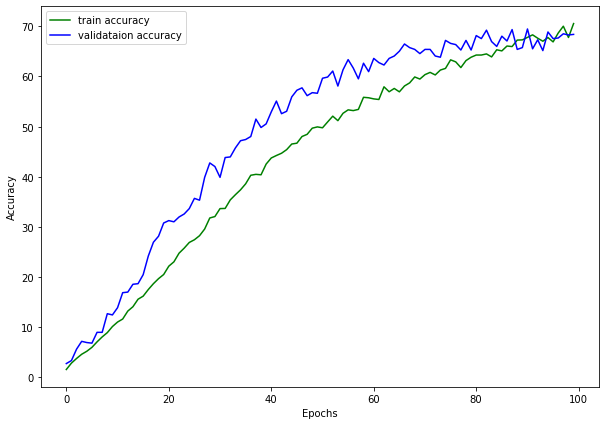

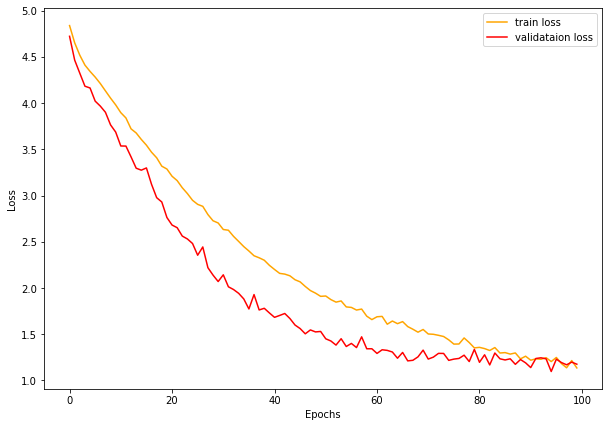

In [6]:
# train the model
train_loss, val_loss, train_acc, val_acc, use_amp = train(100, model_scratch, criterion_scratch, optimizer_scratch, exp_lr_scheduler)

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_acc, color='green', label='train accuracy')
plt.plot(val_acc, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"./graphs/condense_amp_{use_amp}_accuracy.png")
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./graphs/condense_amp_{use_amp}_loss.png")
plt.show()

In [7]:
def test(model, criterion):
    since = time.time()
    # monitor test loss and accuracy
    print("Evaluating model")
    print("-" * 10)
    model.eval()
    
    test_loss = 0.
    test_acc = 0.
    correct = 0.
    total = 0.
    
    for i, data in enumerate(dataloaders[TEST]):
        images, target = data
        # move to GPU
        images, target = images.to(device), target.to(device)
                
        # forward pass: compute predicted outputs by passing inputs to the model
        with torch.no_grad():
            outputs = model(images)
            # calculate the loss
            _, preds = torch.max(outputs.data, 1)
            
            #pred = output.data.max(1, keepdim=True)[1]
            loss = criterion(outputs, target)
            # update average test loss  
            test_loss = test_loss + ((1 / (i + 1)) * (loss.item() - test_loss))
                       
            # compare predictions to true label
            total += target.size(0)
            correct += (preds == target).double().sum().item()
            
    avg_loss = test_loss
    elapsed_time = time.time() - since

    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("\nTest Loss: {:.6f}\n".format(avg_loss))
    print("\nTest Accuracy: {:.3f}% {:.0f}/{:.0f}".format(100. * correct / total, correct, total))
    print('-' * 10)

In [8]:
# call test function    
test(model_scratch, criterion_scratch)

Evaluating model
----------
Evaluation completed in 0m 12s

Test Loss: 1.118846


Test Accuracy: 70.335% 588/836
----------
